In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/web3-scamming-dataset/benign_addresses_nft_transactions.csv
/kaggle/input/web3-scamming-dataset/phishing_addresses_all_transactions.csv
/kaggle/input/web3-scamming-dataset/phishing_addresses_nft_transactions.csv
/kaggle/input/web3-scamming-dataset/benign_addresses_all_transactions.csv
/kaggle/input/web3-scamming-dataset/account_level_labeled.parquet
/kaggle/input/web3-scamming-dataset/phishing_addresses.csv
/kaggle/input/web3-scamming-dataset/benign_addresses.csv
/kaggle/input/web3-scamming-dataset/MultiTaskLearning/X_account_features_raw.csv
/kaggle/input/web3-scamming-dataset/MultiTaskLearning/y_account_labels.csv
/kaggle/input/web3-scamming-dataset/MultiTaskLearning/y_trans_labels.csv
/kaggle/input/web3-scamming-dataset/MultiTaskLearning/X_trans_features_raw.csv
/kaggle/input/web3-scamming-dataset/Ethereum-Phising-Dataset/Ethereum-Phising-Dataset/Normal_Account/ERC20_trans_2.csv
/kaggle/input/web3-scamming-dataset/Ethereum-Phising-Dataset/Ethereum-Phising-Dataset/Norma

In [2]:
!pip install shap

In [2]:
"""
NFT Phishing Detection - Multiple Machine Learning Models - OPTIMIZED VERSION
Models: Random Forest, XGBoost, LightGBM, Neural Network (MLP), Logistic Regression
Performance improvements:
1. Pre-grouping transactions by address
2. Pre-parsing function calls once
3. Multiprocessing for parallel address processing
4. Vectorized operations
"""

import pandas as pd
import numpy as np
import json
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import time
import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings('ignore')
tqdm.pandas()

# ============================================================================
# CONFIGURATION - EDIT THIS SECTION
# ============================================================================
# Dataset ratio mode:
#   'all' - Use all addresses and transactions without filtering (default)
#   '1:1' - Balance phishing and benign addresses (filter benign to match phishing count)
RATIO_MODE = 'all'  # 👈 CHANGE THIS: 'all' or '1:1'

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Validate configuration
if RATIO_MODE not in ['all', '1:1']:
    raise ValueError(f"❌ Invalid RATIO_MODE: '{RATIO_MODE}'. Must be 'all' or '1:1'")

print("=" * 80)
print("NFT Phishing Detection - Multiple ML Models Comparison")
print("Models: Random Forest, XGBoost, LightGBM, Neural Network, Logistic Regression")
print(f"Ratio Mode: {RATIO_MODE}")
print("=" * 80)

# ============================================================================
# 1. DATA LOADING & FILTERING
# ============================================================================
print("\n[1/8] Loading data...")
start_time = time.time()

# Load addresses
phishing_addr = pd.read_csv('/kaggle/input/web3-scamming-dataset/phishing_addresses.csv')
benign_addr_all = pd.read_csv('/kaggle/input/web3-scamming-dataset/benign_addresses.csv')

print(f"Phishing addresses: {len(phishing_addr)}")
print(f"Benign addresses (total): {len(benign_addr_all)}")

# Load transactions first
print("\nLoading transactions...")
phishing_txns = pd.read_csv('/kaggle/input/web3-scamming-dataset/phishing_addresses_all_transactions.csv', low_memory=False)
benign_txns_all = pd.read_csv('/kaggle/input/web3-scamming-dataset/benign_addresses_all_transactions.csv', low_memory=False)

print(f"Phishing transactions: {len(phishing_txns)}")
print(f"Benign transactions (total): {len(benign_txns_all)}")

# Normalize addresses for matching
phishing_txns['from_address'] = phishing_txns['from_address'].str.lower()
phishing_txns['to_address'] = phishing_txns['to_address'].str.lower()
benign_txns_all['from_address'] = benign_txns_all['from_address'].str.lower()
benign_txns_all['to_address'] = benign_txns_all['to_address'].str.lower()

# Find benign addresses that actually have transactions in the dataset
benign_addresses_with_txns = set(benign_txns_all['from_address'].unique()) | \
                              set(benign_txns_all['to_address'].unique())
benign_addr_all['address_lower'] = benign_addr_all['address'].str.lower()
benign_addr_with_txns = benign_addr_all[benign_addr_all['address_lower'].isin(benign_addresses_with_txns)].copy()

print(f"Benign addresses with transactions in dataset: {len(benign_addr_with_txns)}")

# Apply ratio mode
if RATIO_MODE == '1:1':
    print("\n📊 Mode: 1:1 (Balanced)")
    print("   - Sampling benign addresses to match phishing address count")
    print("   - Using all transactions from sampled benign addresses")
    
    n_phishing = len(phishing_addr)
    
    if len(benign_addr_with_txns) > n_phishing:
        benign_addr = benign_addr_with_txns.sample(n=n_phishing, random_state=RANDOM_STATE)
        print(f"   - Sampled {len(benign_addr)} benign addresses (matched to {n_phishing} phishing addresses)")
    else:
        benign_addr = benign_addr_with_txns
        print(f"   ⚠️  Only {len(benign_addr)} benign addresses available (less than {n_phishing} phishing addresses)")
    
    # Filter benign transactions to only include selected addresses
    benign_addresses_list = benign_addr['address_lower'].unique()
    benign_txns = benign_txns_all[
        (benign_txns_all['from_address'].isin(benign_addresses_list)) | 
        (benign_txns_all['to_address'].isin(benign_addresses_list))
    ].copy()
    
    print(f"   - Benign transactions after filtering: {len(benign_txns)}")
    
elif RATIO_MODE == 'all':
    print("\n📊 Mode: all (No filtering)")
    print("   - Using all benign addresses and transactions")
    
    benign_addr = benign_addr_with_txns
    benign_txns = benign_txns_all
    
    print(f"   - Benign addresses: {len(benign_addr)}")
    print(f"   - Benign transactions: {len(benign_txns)}")

print(f"\n✓ Final dataset:")
print(f"   Phishing: {len(phishing_addr)} addresses, {len(phishing_txns)} transactions")
print(f"   Benign:   {len(benign_addr)} addresses, {len(benign_txns)} transactions")
print(f"   Ratio:    1:{len(benign_addr)/len(phishing_addr):.2f} (phishing:benign addresses)")
print(f"   Ratio:    1:{len(benign_txns)/len(phishing_txns):.2f} (phishing:benign transactions)")

# ============================================================================
# 2. DATA PREPROCESSING - OPTIMIZED
# ============================================================================
print("\n[2/8] Preprocessing data...")

def preprocess_transactions(df):
    """Preprocess transaction data"""
    df = df.copy()
    
    # Handle empty strings and convert to proper types
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].replace('', np.nan)
    
    # Convert numeric columns
    numeric_cols = ['value', 'gas_used', 'gas_price', 'token_value', 'token_decimal',
                    'nft_floor_price', 'nft_average_price', 'nft_total_volume', 
                    'nft_total_sales', 'nft_num_owners', 'nft_market_cap',
                    'nft_7day_volume', 'nft_7day_sales', 'nft_7day_avg_price']
    
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
    # Convert timestamp
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
    # Addresses already lowercased in loading phase
    # Lowercase contract_address if not already
    if 'contract_address' in df.columns:
        df['contract_address'] = df['contract_address'].str.lower()
    
    return df

phishing_txns = preprocess_transactions(phishing_txns)
benign_txns = preprocess_transactions(benign_txns)

# ============================================================================
# OPTIMIZATION 1: PRE-PARSE FUNCTION CALLS ONCE
# ============================================================================
print("\n[OPTIMIZATION] Pre-parsing function calls for all transactions...")

def parse_function_calls(func_str):
    """Parse function_call column to extract function names"""
    if pd.isna(func_str) or func_str == '' or func_str == '[]':
        return []
    try:
        if isinstance(func_str, str):
            funcs = json.loads(func_str.replace("'", '"'))
            return funcs if isinstance(funcs, list) else []
    except:
        return []
    return []

# Pre-parse function calls for phishing transactions
print("  - Parsing phishing transactions...")
phishing_txns['function_list'] = phishing_txns['function_call'].progress_apply(parse_function_calls)

# Pre-parse function calls for benign transactions
print("  - Parsing benign transactions...")
benign_txns['function_list'] = benign_txns['function_call'].progress_apply(parse_function_calls)

# ============================================================================
# OPTIMIZATION 2: PRE-GROUP TRANSACTIONS BY ADDRESS
# ============================================================================
print("\n[OPTIMIZATION] Pre-grouping transactions by address...")

def create_address_transaction_dict(txns_df, addresses):
    """Create a dictionary mapping addresses to their transactions"""
    addr_txn_dict = {}
    
    # Create indices for faster lookup
    from_grouped = txns_df.groupby('from_address').groups
    to_grouped = txns_df.groupby('to_address').groups
    
    for addr in tqdm(addresses, desc="Grouping addresses", unit="addr"):
        addr_lower = addr.lower()
        
        # Get indices where address appears
        out_indices = from_grouped.get(addr_lower, [])
        in_indices = to_grouped.get(addr_lower, [])
        
        # Store pre-filtered dataframes
        addr_txn_dict[addr_lower] = {
            'out_txns': txns_df.loc[out_indices].copy() if len(out_indices) > 0 else pd.DataFrame(),
            'in_txns': txns_df.loc[in_indices].copy() if len(in_indices) > 0 else pd.DataFrame(),
        }
    
    return addr_txn_dict

print("  - Grouping phishing transactions...")
phishing_addr_dict = create_address_transaction_dict(phishing_txns, phishing_addr['address'].values)

print("  - Grouping benign transactions...")
benign_addr_dict = create_address_transaction_dict(benign_txns, benign_addr['address'].values)

# ============================================================================
# 3. FEATURE ENGINEERING - ADDRESS LEVEL (OPTIMIZED)
# ============================================================================
print("\n[3/8] Engineering address-level features (OPTIMIZED)...")

def extract_single_address_features_optimized(addr, addr_txn_data):
    """Extract features for a single address using pre-grouped data"""
    try:
        addr_lower = addr.lower()
        
        # Get pre-filtered transactions (NO MORE FILTERING!)
        out_txns = addr_txn_data.get('out_txns', pd.DataFrame())
        in_txns = addr_txn_data.get('in_txns', pd.DataFrame())
        
        if len(out_txns) == 0 and len(in_txns) == 0:
            return None
        
        all_txns = pd.concat([out_txns, in_txns]).drop_duplicates('transaction_hash')
        
        # Basic transaction counts
        out_txn_count = len(out_txns)
        in_txn_count = len(in_txns)
        total_txn_count = len(all_txns)
        
        # Neighbor counts
        out_neighbors = out_txns['to_address'].nunique() if len(out_txns) > 0 else 0
        in_neighbors = in_txns['from_address'].nunique() if len(in_txns) > 0 else 0
        
        # NFT-specific features
        if len(in_txns) > 0:
            is_mint = (in_txns['from_address'] == in_txns['contract_address']) | \
                      (in_txns['from_address'].str.startswith('0x0000000000000000000000000000000000000000'))
            mint_txn_count = is_mint.sum()
        else:
            mint_txn_count = 0
        
        # Gift transactions (0 value transfers)
        giftin_ratio = 0
        giftout_ratio = 0
        if len(in_txns) > 0:
            is_gift_in = (in_txns['value'] == 0) & (in_txns['token_value'] > 0)
            giftin_ratio = is_gift_in.mean()
        if len(out_txns) > 0:
            is_gift_out = (out_txns['value'] == 0) & (out_txns['token_value'] > 0)
            giftout_ratio = is_gift_out.mean()
        
        # Collection diversity
        in_collections = in_txns['contract_address'].nunique() if len(in_txns) > 0 else 0
        out_collections = out_txns['contract_address'].nunique() if len(out_txns) > 0 else 0
        
        # NFT counts (using token_value as proxy for nft_number)
        in_nft_num = in_txns['token_value'].sum() if len(in_txns) > 0 else 0
        out_nft_num = out_txns['token_value'].sum() if len(out_txns) > 0 else 0
        
        # Price features
        avg_floor_price_in = in_txns['nft_floor_price'].mean() if len(in_txns) > 0 else 0
        avg_floor_price_out = out_txns['nft_floor_price'].mean() if len(out_txns) > 0 else 0
        avg_nft_price_in = in_txns['nft_average_price'].mean() if len(in_txns) > 0 else 0
        avg_nft_price_out = out_txns['nft_average_price'].mean() if len(out_txns) > 0 else 0
        
        max_floor_price = all_txns['nft_floor_price'].max() if len(all_txns) > 0 else 0
        total_volume = all_txns['nft_total_volume'].sum() if len(all_txns) > 0 else 0
        
        # Function call analysis - using pre-parsed function_list
        all_functions = []
        if 'function_list' in all_txns.columns:
            all_functions = [f for funcs in all_txns['function_list'] for f in funcs]
        
        # Suspicious function patterns
        suspicious_patterns = [
            'setApprovalForAll', 'approve', 'transferFrom', 'safeTransferFrom',
            'batchTransfer', 'multiTransfer', 'permit', 'delegateCall'
        ]
        
        suspicious_func_count = 0
        transfer_func_count = 0
        approval_func_count = 0
        
        for func in all_functions:
            func_lower = func.lower()
            if any(pattern.lower() in func_lower for pattern in suspicious_patterns):
                suspicious_func_count += 1
            if 'transfer' in func_lower:
                transfer_func_count += 1
            if 'approv' in func_lower or 'permit' in func_lower:
                approval_func_count += 1
        
        unique_functions = len(set(all_functions))
        
        # Time-based features
        if len(all_txns) > 0 and 'timestamp' in all_txns.columns:
            all_txns_sorted = all_txns.sort_values('timestamp')
            time_diffs = all_txns_sorted['timestamp'].diff().dt.total_seconds()
            avg_time_between_txns = time_diffs.mean() if len(time_diffs) > 1 else 0
            std_time_between_txns = time_diffs.std() if len(time_diffs) > 1 else 0
            
            # Activity duration
            first_txn = all_txns_sorted['timestamp'].min()
            last_txn = all_txns_sorted['timestamp'].max()
            activity_duration_days = (last_txn - first_txn).total_seconds() / 86400 if pd.notna(first_txn) else 0
        else:
            avg_time_between_txns = 0
            std_time_between_txns = 0
            activity_duration_days = 0
        
        # Money laundering indicators
        turnover_ratio = out_txn_count / in_txn_count if in_txn_count > 0 else 0
        rapid_flip_ratio = min(out_txn_count / in_txn_count, 5) if in_txn_count > 0 else 0
        total_collections = in_collections + out_collections
        
        # NFT dumping indicators
        nft_dump_ratio = out_nft_num / in_nft_num if in_nft_num > 0 else 0
        txn_velocity = total_txn_count / max(activity_duration_days, 1)
        price_drop_indicator = (avg_floor_price_out / avg_floor_price_in) if avg_floor_price_in > 0 else 1
        
        # Gas usage patterns
        avg_gas_used = all_txns['gas_used'].mean() if len(all_txns) > 0 else 0
        avg_gas_price = all_txns['gas_price'].mean() if len(all_txns) > 0 else 0
        
        # Value transferred
        total_value_in = in_txns['value'].sum() if len(in_txns) > 0 else 0
        total_value_out = out_txns['value'].sum() if len(out_txns) > 0 else 0
        avg_value_in = in_txns['value'].mean() if len(in_txns) > 0 else 0
        avg_value_out = out_txns['value'].mean() if len(out_txns) > 0 else 0
        
        # Network metrics
        in_out_ratio = in_txn_count / out_txn_count if out_txn_count > 0 else 0
        neighbor_ratio = out_neighbors / in_neighbors if in_neighbors > 0 else 0
        
        features = {
            'address': addr,
            # Basic transaction features
            'out_txn': out_txn_count,
            'in_txn': in_txn_count,
            'total_txn': total_txn_count,
            'outNeighborNum': out_neighbors,
            'inNeighborNum': in_neighbors,
            
            # NFT-specific features
            'miningTxnNum': mint_txn_count,
            'giftinTxn_ratio': giftin_ratio,
            'giftoutTxn_ratio': giftout_ratio,
            'inNFTCollection': in_collections,
            'outNFTCollection': out_collections,
            'total_collections': total_collections,
            'inNFTNum': in_nft_num,
            'outNFTNum': out_nft_num,
            
            # Price features
            'avg_floor_price_in': avg_floor_price_in,
            'avg_floor_price_out': avg_floor_price_out,
            'avg_nft_price_in': avg_nft_price_in,
            'avg_nft_price_out': avg_nft_price_out,
            'max_floor_price': max_floor_price,
            'total_volume': total_volume,
            'price_drop_indicator': price_drop_indicator,
            
            # Function call features
            'suspicious_func_count': suspicious_func_count,
            'transfer_func_count': transfer_func_count,
            'approval_func_count': approval_func_count,
            'unique_functions': unique_functions,
            
            # Time features
            'avg_time_between_txns': avg_time_between_txns,
            'std_time_between_txns': std_time_between_txns,
            'activity_duration_days': activity_duration_days,
            'txn_velocity': txn_velocity,
            
            # Money laundering indicators
            'turnover_ratio': turnover_ratio,
            'rapid_flip_ratio': rapid_flip_ratio,
            'nft_dump_ratio': nft_dump_ratio,
            
            # Value features
            'total_value_in': total_value_in,
            'total_value_out': total_value_out,
            'avg_value_in': avg_value_in,
            'avg_value_out': avg_value_out,
            
            # Network metrics
            'in_out_ratio': in_out_ratio,
            'neighbor_ratio': neighbor_ratio,
            
            # Gas features
            'avg_gas_used': avg_gas_used,
            'avg_gas_price': avg_gas_price,
        }
        
        return features
    except Exception as e:
        print(f"Error processing address {addr}: {str(e)}")
        return None

def extract_address_features_optimized(addr_dict, addresses):
    """Extract features for each address using pre-grouped data"""
    print(f"Processing {len(addresses)} addresses with pre-grouped data...")
    
    features_list = []
    for addr in tqdm(addresses, desc="Processing addresses", unit="addr"):
        addr_lower = addr.lower()
        addr_txn_data = addr_dict.get(addr_lower, {})
        features = extract_single_address_features_optimized(addr, addr_txn_data)
        if features is not None:
            features_list.append(features)
    
    return pd.DataFrame(features_list)

# Extract features for phishing addresses
print("\nExtracting phishing address features...")
phishing_features = extract_address_features_optimized(phishing_addr_dict, phishing_addr['address'].values)
phishing_features['label'] = 1
print(f"✓ Extracted features for {len(phishing_features)} phishing addresses")

# Extract features for benign addresses
print("\nExtracting benign address features...")
benign_features = extract_address_features_optimized(benign_addr_dict, benign_addr['address'].values)
benign_features['label'] = 0
print(f"✓ Extracted features for {len(benign_features)} benign addresses")

# Combine address features
address_features_df = pd.concat([phishing_features, benign_features], ignore_index=True)

# Replace inf values with large numbers
address_features_df = address_features_df.replace([np.inf, -np.inf], np.nan)
address_features_df = address_features_df.fillna(0)

print(f"Total addresses with features: {len(address_features_df)}")
print(f"  - Phishing: {len(phishing_features)}")
print(f"  - Benign: {len(benign_features)}")

# ============================================================================
# 4. FEATURE ENGINEERING - TRANSACTION LEVEL
# ============================================================================
print("\n[4/8] Engineering transaction-level features...")

def extract_transaction_features(txns_df):
    """Extract features for each transaction"""
    print(f"Processing {len(txns_df):,} transactions...")
    df = txns_df.copy()
    
    # Function features - using pre-parsed function_list
    print("  - Extracting function features...")
    df['num_functions'] = df['function_list'].apply(len)
    
    # Suspicious function flags
    def has_suspicious_func(funcs):
        suspicious_patterns = ['setApprovalForAll', 'approve', 'transferFrom', 'safeTransferFrom',
                               'batchTransfer', 'multiTransfer', 'permit', 'delegateCall']
        for func in funcs:
            if any(pattern.lower() in func.lower() for pattern in suspicious_patterns):
                return 1
        return 0
    
    def has_transfer_func(funcs):
        return 1 if any('transfer' in f.lower() for f in funcs) else 0
    
    def has_approval_func(funcs):
        return 1 if any(('approv' in f.lower() or 'permit' in f.lower()) for f in funcs) else 0
    
    df['has_suspicious_func'] = df['function_list'].progress_apply(has_suspicious_func)
    df['has_transfer_func'] = df['function_list'].progress_apply(has_transfer_func)
    df['has_approval_func'] = df['function_list'].progress_apply(has_approval_func)
    
    # Value features
    print("  - Computing value and transaction type features...")
    df['is_zero_value'] = (df['value'] == 0).astype(int)
    df['is_gift'] = ((df['value'] == 0) & (df['token_value'] > 0)).astype(int)
    
    # Check if mint
    df['is_mint'] = ((df['from_address'] == df['contract_address']) | 
                     (df['from_address'].str.startswith('0x0000000000000000000000000000000000000000'))).astype(int)
    
    # Price-based features
    print("  - Computing price and market features...")
    df['has_floor_price'] = (df['nft_floor_price'] > 0).astype(int)
    df['high_value_nft'] = (df['nft_floor_price'] > df['nft_floor_price'].quantile(0.75)).astype(int)
    
    # Market activity features
    df['high_volume_collection'] = (df['nft_total_volume'] > df['nft_total_volume'].quantile(0.75)).astype(int)
    df['low_owners'] = (df['nft_num_owners'] < df['nft_num_owners'].quantile(0.25)).astype(int)
    
    # Gas features
    df['high_gas'] = (df['gas_used'] > df['gas_used'].quantile(0.75)).astype(int)
    
    # Transaction type
    df['is_erc721'] = (df['tx_type'] == 'erc721').astype(int)
    df['is_erc1155'] = (df['tx_type'] == 'erc1155').astype(int)
    
    feature_cols = [
        'value', 'gas_used', 'gas_price', 'token_value',
        'nft_floor_price', 'nft_average_price', 'nft_total_volume',
        'nft_total_sales', 'nft_num_owners', 'nft_market_cap',
        'nft_7day_volume', 'nft_7day_sales', 'nft_7day_avg_price',
        'num_functions', 'has_suspicious_func', 'has_transfer_func', 'has_approval_func',
        'is_zero_value', 'is_gift', 'is_mint',
        'has_floor_price', 'high_value_nft', 'high_volume_collection',
        'low_owners', 'high_gas', 'is_erc721', 'is_erc1155'
    ]
    
    print("  ✓ Transaction feature extraction complete!")
    return df[feature_cols + ['label']]

# Prepare transaction datasets
phishing_txns['label'] = 1
benign_txns['label'] = 0

transaction_df = pd.concat([phishing_txns, benign_txns], ignore_index=True)
transaction_features_df = extract_transaction_features(transaction_df)

# Handle missing values
transaction_features_df = transaction_features_df.replace([np.inf, -np.inf], np.nan)
transaction_features_df = transaction_features_df.fillna(0)

print(f"\nTotal transactions with features (before balancing): {len(transaction_features_df)}")
print(f"  - Phishing: {(transaction_features_df['label'] == 1).sum()}")
print(f"  - Benign: {(transaction_features_df['label'] == 0).sum()}")

# Balance transaction dataset - sample benign transactions to match phishing count
n_phishing_txns = (transaction_features_df['label'] == 1).sum()
n_benign_txns = (transaction_features_df['label'] == 0).sum()

if n_benign_txns > n_phishing_txns:
    print(f"\n⚖️  Balancing transactions for training...")
    print(f"   Sampling {n_phishing_txns:,} benign transactions (from {n_benign_txns:,})")
    
    # Separate phishing and benign
    phishing_txn_features = transaction_features_df[transaction_features_df['label'] == 1]
    benign_txn_features = transaction_features_df[transaction_features_df['label'] == 0]
    
    # Sample benign transactions
    benign_txn_features_sampled = benign_txn_features.sample(n=n_phishing_txns, random_state=RANDOM_STATE)
    
    # Combine
    transaction_features_df = pd.concat([phishing_txn_features, benign_txn_features_sampled], ignore_index=True)
    
    # Shuffle
    transaction_features_df = transaction_features_df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    
    print(f"   ✓ Balanced to {len(transaction_features_df):,} transactions (1:1 ratio)")
else:
    print(f"\n⚠️  Benign transactions ({n_benign_txns:,}) <= Phishing transactions ({n_phishing_txns:,})")
    print(f"   Using all available benign transactions")

print(f"\n✓ Final transaction dataset for training:")
print(f"  Total: {len(transaction_features_df):,} transactions")
print(f"  - Phishing: {(transaction_features_df['label'] == 1).sum():,}")
print(f"  - Benign: {(transaction_features_df['label'] == 0).sum():,}")
print(f"  - Ratio: 1:{(transaction_features_df['label'] == 0).sum()/(transaction_features_df['label'] == 1).sum():.2f}")
# ============================================================================
# 5. FEATURE SELECTION USING LIGHTGBM
# ============================================================================
import lightgbm as lgb
import os

print("\n[5/8] Feature Selection using LightGBM...")
os.makedirs("/kaggle/working/Feature_Importance", exist_ok=True)

def select_top_features_lgbm(df, dataset_name, random_state=42, top_k=15):
    """
    Perform feature selection using LightGBM based on gain importance.
    Saves:
      - Feature importance plot (.png)
      - Top feature list (.json)
    """
    print(f"\n⚙️ Selecting top {top_k} features for {dataset_name} dataset...")
    X = df.drop(columns=['label', 'address'], errors='ignore')
    y = df['label']

    # Stratified 7/2/1 split
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=random_state
    )

    # Train LightGBM model
    model = lgb.LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        objective='binary',
        random_state=random_state,
        n_jobs=-1
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
    )

    # Compute feature importance
    importance = model.booster_.feature_importance(importance_type='gain')
    feature_names = model.booster_.feature_name()
    fi_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values(by='importance', ascending=False).reset_index(drop=True)

    # Select top features
    top_features = fi_df.head(top_k)
    print(f"Top {top_k} features for {dataset_name}:\n{top_features}")

    # Save JSON
    json_path = f"/kaggle/working/Feature_Importance/{dataset_name}_top{top_k}_features.json"
    top_features[['feature', 'importance']].to_json(json_path, orient='records', indent=4)
    print(f"✓ Saved feature list to {json_path}")

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
    plt.title(f"Top {top_k} Important Features - {dataset_name}")
    plt.xlabel("Gain Importance")
    plt.ylabel("Feature Name")
    plt.tight_layout()
    plot_path = f"/kaggle/working/Feature_Importance/{dataset_name}_FeatureImportance.png"
    plt.savefig(plot_path)
    plt.close()
    print(f"✓ Saved feature importance plot to {plot_path}")

    return top_features['feature'].tolist(), (X_train, X_val, X_test, y_train, y_val, y_test)

# --- Run feature selection for both datasets ---
address_top_features, address_splits = select_top_features_lgbm(address_features_df, "AccountLevel")
transaction_top_features, transaction_splits = select_top_features_lgbm(transaction_features_df, "TransactionLevel")

print("\n✓ Feature selection completed successfully!")
print(f"   - Account-Level top features saved at: /kaggle/working/Feature_Importance/AccountLevel_top15_features.json")
print(f"   - Transaction-Level top features saved at: /kaggle/working/Feature_Importance/TransactionLevel_top15_features.json")



NFT Phishing Detection - Multiple ML Models Comparison
Models: Random Forest, XGBoost, LightGBM, Neural Network, Logistic Regression
Ratio Mode: all

[1/8] Loading data...
Phishing addresses: 2581
Benign addresses (total): 5680

Loading transactions...
Phishing transactions: 760614
Benign transactions (total): 11185669
Benign addresses with transactions in dataset: 5680

📊 Mode: all (No filtering)
   - Using all benign addresses and transactions
   - Benign addresses: 5680
   - Benign transactions: 11185669

✓ Final dataset:
   Phishing: 2581 addresses, 760614 transactions
   Benign:   5680 addresses, 11185669 transactions
   Ratio:    1:2.20 (phishing:benign addresses)
   Ratio:    1:14.71 (phishing:benign transactions)

[2/8] Preprocessing data...

[OPTIMIZATION] Pre-parsing function calls for all transactions...
  - Parsing phishing transactions...


100%|██████████| 760614/760614 [00:02<00:00, 312010.97it/s]


  - Parsing benign transactions...


100%|██████████| 11185669/11185669 [00:15<00:00, 742023.92it/s] 



[OPTIMIZATION] Pre-grouping transactions by address...
  - Grouping phishing transactions...


Grouping addresses: 100%|██████████| 2581/2581 [00:05<00:00, 432.99addr/s]


  - Grouping benign transactions...


Grouping addresses: 100%|██████████| 5680/5680 [00:25<00:00, 219.02addr/s]



[3/8] Engineering address-level features (OPTIMIZED)...

Extracting phishing address features...
Processing 2581 addresses with pre-grouped data...


Processing addresses: 100%|██████████| 2581/2581 [00:14<00:00, 174.34addr/s]


✓ Extracted features for 2581 phishing addresses

Extracting benign address features...
Processing 5680 addresses with pre-grouped data...


Processing addresses: 100%|██████████| 5680/5680 [01:00<00:00, 94.12addr/s] 


✓ Extracted features for 5680 benign addresses
Total addresses with features: 8261
  - Phishing: 2581
  - Benign: 5680

[4/8] Engineering transaction-level features...
Processing 11,946,283 transactions...
  - Extracting function features...


100%|██████████| 11946283/11946283 [00:11<00:00, 1073801.74it/s]


  - Computing value and transaction type features...
  - Computing price and market features...
  ✓ Transaction feature extraction complete!

Total transactions with features (before balancing): 11946283
  - Phishing: 760614
  - Benign: 11185669

⚖️  Balancing transactions for training...
   Sampling 760,614 benign transactions (from 11,185,669)
   ✓ Balanced to 1,521,228 transactions (1:1 ratio)

✓ Final transaction dataset for training:
  Total: 1,521,228 transactions
  - Phishing: 760,614
  - Benign: 760,614
  - Ratio: 1:1.00

[5/8] Feature Selection using LightGBM...

⚙️ Selecting top 15 features for AccountLevel dataset...
[LightGBM] [Info] Number of positive: 1806, number of negative: 3976
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7232
[LightGBM] [Info] Number of data points in the train set: 5782, number of used features: 38
[LightG

In [3]:
# ============================================================================
# TIẾP TỤC TỪ KERNEL TRƯỚC (BẮT ĐẦU TỪ STEP 6)
# PHIÊN BẢN TỰ VIẾT FT-TRANSFORMER (KHÔNG CẦN CÀI ĐẶT)
# ============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
import json
from tqdm.notebook import tqdm

# --- BỎ CÀI ĐẶT VÀ IMPORT ---
# KHÔNG CẦN CÀI ĐẶT HAY IMPORT FTTransformer TỪ BÊN NGOÀI NỮA
# !pip install ... (ĐÃ XÓA)
# from ft_transformer_pytorch import FTTransformer (ĐÃ XÓA)
# --- KẾT THÚC BỎ CÀI ĐẶT ---


# ============================================================================
# CONFIGURATION
# ============================================================================
# (Giữ nguyên cấu hình của bạn)
BATCH_SIZE = 1024
EPOCHS = 20
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = 15 

MLP_SHARED_DIM = 128
MLP_HEAD_HIDDEN_DIM = 64

FT_ATTN_HEADS = 8
FT_NUM_LAYERS = 6
FT_EMBED_DIM = 64 

print(f"\n[INFO] Sử dụng thiết bị: {DEVICE}")
print(f"[INFO] Input feature dimension: {INPUT_DIM} (Top 15)")

# ============================================================================
# 6. DATA PREPARATION (SCALING & DATALOADERS)
# ============================================================================
print("\n[6/13] Chuẩn bị dữ liệu (Scaling & DataLoaders)...")

# (Giả định các biến ..._splits, ..._top_features đã có từ trước)
# --- 6.1. Tải lại splits và features (Giả định đã có) ---
(X_train_addr_df, X_val_addr_df, X_test_addr_df, 
 y_train_addr, y_val_addr, y_test_addr) = address_splits

(X_train_txn_df, X_val_txn_df, X_test_txn_df, 
 y_train_txn, y_val_txn, y_test_txn) = transaction_splits

# --- 6.2. Lọc Top 15 Features ---
print("  - Lọc Top 15 features...")
X_train_addr = X_train_addr_df[address_top_features]
X_val_addr = X_val_addr_df[address_top_features]
X_test_addr = X_test_addr_df[address_top_features]

X_train_txn = X_train_txn_df[transaction_top_features]
X_val_txn = X_val_txn_df[transaction_top_features]
X_test_txn = X_test_txn_df[transaction_top_features]

# --- 6.3. Scaling Data ---
print("  - Scaling dữ liệu (StandardScaler)...")
# Account Level
scaler_addr = StandardScaler()
X_train_addr_scaled = scaler_addr.fit_transform(X_train_addr)
X_val_addr_scaled = scaler_addr.transform(X_val_addr)
X_test_addr_scaled = scaler_addr.transform(X_test_addr)

# Transaction Level
scaler_txn = StandardScaler()
X_train_txn_scaled = scaler_txn.fit_transform(X_train_txn)
X_val_txn_scaled = scaler_txn.transform(X_val_txn)
X_test_txn_scaled = scaler_txn.transform(X_test_txn)

# --- 6.4. Chuyển đổi sang Tensors ---
print("  - Chuyển đổi sang PyTorch Tensors...")
# Account Tensors
X_train_addr_tensor = torch.tensor(X_train_addr_scaled, dtype=torch.float32)
y_train_addr_tensor = torch.tensor(y_train_addr.values, dtype=torch.float32)
X_val_addr_tensor = torch.tensor(X_val_addr_scaled, dtype=torch.float32)
y_val_addr_tensor = torch.tensor(y_val_addr.values, dtype=torch.float32)
X_test_addr_tensor = torch.tensor(X_test_addr_scaled, dtype=torch.float32)
y_test_addr_tensor = torch.tensor(y_test_addr.values, dtype=torch.float32)

# Transaction Tensors
X_train_txn_tensor = torch.tensor(X_train_txn_scaled, dtype=torch.float32)
y_train_txn_tensor = torch.tensor(y_train_txn.values, dtype=torch.float32)
X_val_txn_tensor = torch.tensor(X_val_txn_scaled, dtype=torch.float32)
y_val_txn_tensor = torch.tensor(y_val_txn.values, dtype=torch.float32)
X_test_txn_tensor = torch.tensor(X_test_txn_scaled, dtype=torch.float32)
y_test_txn_tensor = torch.tensor(y_test_txn.values, dtype=torch.float32)

# --- 6.5. Tạo DataLoaders ---
print("  - Tạo DataLoaders...")
# Account DataLoaders
train_addr_dataset = TensorDataset(X_train_addr_tensor, y_train_addr_tensor)
val_addr_dataset = TensorDataset(X_val_addr_tensor, y_val_addr_tensor)
test_addr_dataset = TensorDataset(X_test_addr_tensor, y_test_addr_tensor)

train_addr_loader = DataLoader(train_addr_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_addr_loader = DataLoader(val_addr_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_addr_loader = DataLoader(test_addr_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Transaction DataLoaders
train_txn_dataset = TensorDataset(X_train_txn_tensor, y_train_txn_tensor)
val_txn_dataset = TensorDataset(X_val_txn_tensor, y_val_txn_tensor)
test_txn_dataset = TensorDataset(X_test_txn_tensor, y_test_txn_tensor)

train_txn_loader = DataLoader(train_txn_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_txn_loader = DataLoader(val_txn_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_txn_loader = DataLoader(test_txn_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("✓ Hoàn thành chuẩn bị dữ liệu.")

# ============================================================================
# 7. MODEL DEFINITIONS (MLP & FT-TRANSFORMER)
# ============================================================================
print("\n[7/13] Định nghĩa kiến trúc mô hình MTL...")

# --- BẮT ĐẦU: TỰ ĐỊNH NGHĨA FTTransformer ---
# Đây là phiên bản FTTransformer tự viết, thay thế cho thư viện pip
class FTTransformer(nn.Module):
    def __init__(self, *, 
                 categories,          
                 num_continuous,      # Numbers feature continuous
                 dim,                 # dimension of embedding
                 depth,               # Numbers of transformer layer
                 heads,               # Numbers of attention heads
                 dim_feedforward = None, # Kích thước FFN
                 attn_dropout = 0.1,  # (Không dùng trực tiếp, dùng ff_dropout)
                 ff_dropout = 0.1     # Dropout for encoder layer
                ):
        super().__init__()
        
        # Thiết lập FFN dimension
        dim_feedforward = dim * 4 if dim_feedforward is None else dim_feedforward
        
        # --- 1. CLS Token ---
        # Token này sẽ được thêm vào đầu chuỗi features
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        # --- 2. Categorical Feature Embeddings ---
        # (Trong trường hợp của bạn, 'categories' là rỗng nên list này sẽ rỗng)
        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(n_cats, dim) for n_cats in categories
        ])

        # --- 3. Continuous Feature Tokenizer ---
        # Đây là phần quan trọng: biến N features continuous thành N token
        # (B, N) -> (B, N, 1)
        # nn.Linear(1, dim) sẽ biến (B, N, 1) -> (B, N, dim)
        # Thêm một bias riêng cho mỗi feature
        self.cont_projection = nn.Linear(1, dim)
        self.cont_bias = nn.Parameter(torch.randn(num_continuous, dim))

        # --- 4. Transformer Encoder ---
        # Sử dụng nn.TransformerEncoderLayer có sẵn của PyTorch
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, 
            nhead=heads, 
            dim_feedforward=dim_feedforward, 
            dropout=ff_dropout, # Dropout cho cả attn và ffn
            activation='gelu',  # Thường dùng GELU trong Transformer
            batch_first=True    # Quan trọng: (Batch, Seq, Dim)
        )
        
        self.transformer = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=depth
        )

    def forward(self, x_categ, x_cont):
        # x_categ: (B, N_cat) - (Trong TH của bạn là tensor rỗng)
        # x_cont: (B, N_cont) - (Trong TH của bạn là (B, 15))
        
        B = x_cont.shape[0]
        
        # --- Tokenize Continuous Features ---
        # (B, 15) -> (B, 15, 1)
        x_cont_unsqueezed = x_cont.unsqueeze(-1)
        # (B, 15, 1) -> (B, 15, dim) + (15, dim) = (B, 15, dim)
        x_cont_emb = self.cont_projection(x_cont_unsqueezed) + self.cont_bias

        # --- Tokenize Categorical Features ---
        if len(self.cat_embeddings) > 0:
            cat_embeddings_list = []
            for i, emb_layer in enumerate(self.cat_embeddings):
                # (B,) -> (B, dim)
                cat_embeddings_list.append(emb_layer(x_categ[:, i]))
            # [(B, dim), (B, dim), ...] -> (B, N_cat, dim)
            x_cat_emb = torch.stack(cat_embeddings_list, dim=1)
            # Nối 2 loại feature lại
            all_embeddings = torch.cat([x_cat_emb, x_cont_emb], dim=1)
        else:
            # (Trường hợp của bạn: chỉ có continuous features)
            all_embeddings = x_cont_emb # (B, 15, dim)
            
        # --- Prepend CLS Token ---
        # (1, 1, dim) -> (B, 1, dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        
        # Nối CLS token vào đầu chuỗi: (B, 1+15, dim)
        x = torch.cat([cls_tokens, all_embeddings], dim=1)
        
        # --- Pass through Transformer ---
        # (B, 1+15, dim) -> (B, 1+15, dim)
        transformer_output = self.transformer(x)
        
        # --- Lấy output của CLS token ---
        # (chỉ lấy token đầu tiên) -> (B, dim)
        cls_output = transformer_output[:, 0, :]
        
        return cls_output
# --- KẾT THÚC: TỰ ĐỊNH NGHĨA FTTransformer ---


# --- 7.1. MTL MLP (Giữ nguyên code của bạn) ---
class MTL_MLP(nn.Module):
    def __init__(self, input_dim, shared_dim, head_hidden_dim):
        super(MTL_MLP, self).__init__()
        # Shared Backbone
        self.shared_backbone = nn.Sequential(
            nn.Linear(input_dim, shared_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(shared_dim, shared_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Task 1 Head (Transaction Phishing)
        self.task1_head = nn.Sequential(
            nn.Linear(shared_dim, head_hidden_dim),
            nn.ReLU(),
            nn.Linear(head_hidden_dim, 1) # Output logits
        )
        
        # Task 2 Head (Account Phishing)
        self.task2_head = nn.Sequential(
            nn.Linear(shared_dim, head_hidden_dim),
            nn.ReLU(),
            nn.Linear(head_hidden_dim, 1) # Output logits
        )

    def forward(self, x, task_id):
        # Đổi tên x thành x_cont để nhất quán
        x_cont = x 
        
        shared_output = self.shared_backbone(x_cont)
        
        if task_id == 'transaction':
            return self.task1_head(shared_output)
        elif task_id == 'account':
            return self.task2_head(shared_output)
        else:
            raise ValueError(f"Unknown task_id: {task_id}")

print("  - Định nghĩa MTL_MLP.")

# --- 7.2. MTL FT-Transformer (Giữ nguyên code của bạn) ---
# Class này của bạn sẽ tự động sử dụng class FTTransformer tự viết ở trên
class MTL_FTTransformer(nn.Module):
    def __init__(self, n_cont_features, embed_dim, attn_heads, num_layers, head_hidden_dim):
        super(MTL_FTTransformer, self).__init__()
        
        # Shared Backbone (SỬ DỤNG CLASS FTTransformer TỰ VIẾT)
        self.shared_backbone = FTTransformer(
            categories = (),      # Không có features categorical
            num_continuous = n_cont_features, # 15
            dim = embed_dim,                  # Kích thước embedding
            depth = num_layers,               # Số lớp transformer
            heads = attn_heads,               # Số attention heads
            attn_dropout = 0.2,               # (Tham số này được truyền vào)
            ff_dropout = 0.2                  # (Tham số này được truyền vào)
        )
        
        # Task 1 Head (Transaction Phishing)
        self.task1_head = nn.Sequential(
            nn.Linear(embed_dim, head_hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(head_hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(head_hidden_dim, 1) # Output logits
        )
        
        # Task 2 Head (Account Phishing)
        self.task2_head = nn.Sequential(
            nn.Linear(embed_dim, head_hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(head_hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(head_hidden_dim, 1) # Output logits
        )

    def forward(self, x_cont, task_id):
        # FT-Transformer yêu cầu (x_categ, x_cont)
        # Tạo một tensor categorical rỗng
        batch_size = x_cont.size(0)
        x_categ = torch.empty(batch_size, 0, dtype=torch.long, device=x_cont.device)
        
        # Pass qua shared backbone (class tự viết)
        shared_output = self.shared_backbone(x_categ, x_cont)
        
        if task_id == 'transaction':
            return self.task1_head(shared_output)
        elif task_id == 'account':
            return self.task2_head(shared_output)
        else:
            raise ValueError(f"Unknown task_id: {task_id}")

print("  - Định nghĩa MTL_FTTransformer (sử dụng class tự viết).")
print("✓ Hoàn thành định nghĩa mô hình.")

# ============================================================================
# 8. TRAINING & EVALUATION UTILITIES
# ============================================================================
print("\n[8/13] Định nghĩa các hàm hỗ trợ Training và Plotting...")

# (Giữ nguyên 100% code các hàm hỗ trợ của bạn)
def plot_metrics(history, model_name, save_path):
    """Vẽ và lưu plot loss, accuracy, và recall."""
    epochs = range(1, len(history['train_loss_txn']) + 1)
    
    plt.figure(figsize=(20, 12))
    
    # --- Loss Plot ---
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train_loss_txn'], 'b-', label='Train Loss (Transaction)')
    plt.plot(epochs, history['train_loss_addr'], 'c-', label='Train Loss (Account)')
    plt.plot(epochs, history['val_loss_txn'], 'b--', label='Val Loss (Transaction)')
    plt.plot(epochs, history['val_loss_addr'], 'c--', label='Val Loss (Account)')
    plt.title(f'Training & Validation Loss - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # --- Accuracy Plot ---
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['train_acc_txn'], 'g-', label='Train Acc (Transaction)')
    plt.plot(epochs, history['train_acc_addr'], 'm-', label='Train Acc (Account)')
    plt.plot(epochs, history['val_acc_txn'], 'g--', label='Val Acc (Transaction)')
    plt.plot(epochs, history['val_acc_addr'], 'm--', label='Val Acc (Account)')
    plt.title(f'Training & Validation Accuracy - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # --- Recall Plot (Quan trọng) ---
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['train_recall_txn'], 'r-', label='Train Recall (Transaction)')
    plt.plot(epochs, history['train_recall_addr'], 'y-', label='Train Recall (Account)')
    plt.plot(epochs, history['val_recall_txn'], 'r--', label='Val Recall (Transaction)')
    plt.plot(epochs, history['val_recall_addr'], 'y--', label='Val Recall (Account)')
    plt.title(f'Training & Validation Recall - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)
    
    # --- F1-Score Plot ---
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history['train_f1_txn'], 'k-', label='Train F1 (Transaction)')
    plt.plot(epochs, history['train_f1_addr'], 'b-', label='Train F1 (Account)')
    plt.plot(epochs, history['val_f1_txn'], 'k--', label='Val F1 (Transaction)')
    plt.plot(epochs, history['val_f1_addr'], 'b--', label='Val F1 (Account)')
    plt.title(f'Training & Validation F1-Score - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plot_filename = os.path.join(save_path, f"{model_name}_training_plots.png")
    plt.savefig(plot_filename)
    plt.close()
    print(f"  ✓ Đã lưu training plots tại: {plot_filename}")

def calculate_metrics(y_true, y_pred_logits):
    """Tính toán metrics từ logits."""
    y_pred_probs = torch.sigmoid(y_pred_logits).cpu().numpy()
    y_pred_labels = (y_pred_probs > 0.5).astype(int)
    y_true_labels = y_true.cpu().numpy()
    
    acc = accuracy_score(y_true_labels, y_pred_labels)
    precision = precision_score(y_true_labels, y_pred_labels, zero_division=0)
    recall = recall_score(y_true_labels, y_pred_labels, zero_division=0)
    f1 = f1_score(y_true_labels, y_pred_labels, zero_division=0)
    try:
        auc = roc_auc_score(y_true_labels, y_pred_probs)
    except ValueError:
        auc = 0.5 # Xử lý trường hợp chỉ có 1 class trong batch
    
    return acc, precision, recall, f1, auc

def train_model(model, model_name, train_txn_loader, val_txn_loader, train_addr_loader, val_addr_loader, optimizer, criterion, epochs, device, save_path):
    
    os.makedirs(save_path, exist_ok=True)
    model_save_path = os.path.join(save_path, f"{model_name}_best.pth")
    
    history = {
        'train_loss_txn': [], 'val_loss_txn': [],
        'train_acc_txn': [], 'val_acc_txn': [],
        'train_recall_txn': [], 'val_recall_txn': [],
        'train_f1_txn': [], 'val_f1_txn': [],
        'train_loss_addr': [], 'val_loss_addr': [],
        'train_acc_addr': [], 'val_acc_addr': [],
        'train_recall_addr': [], 'val_recall_addr': [],
        'train_f1_addr': [], 'val_f1_addr': []
    }
    
    best_val_macro_f1 = -1.0
    
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        
        # --- Training Phase ---
        train_losses_txn, train_losses_addr = [], []
        train_preds_txn, train_labels_txn = [], []
        train_preds_addr, train_labels_addr = [], []
        
        # Train Task 1 (Transaction)
        for X_batch, y_batch in train_txn_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch, task_id='transaction').squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_losses_txn.append(loss.item())
            train_preds_txn.append(outputs.detach())
            train_labels_txn.append(y_batch.detach())

        # Train Task 2 (Account)
        for X_batch, y_batch in train_addr_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch, task_id='account').squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_losses_addr.append(loss.item())
            train_preds_addr.append(outputs.detach())
            train_labels_addr.append(y_batch.detach())

        # --- Validation Phase ---
        model.eval()
        val_losses_txn, val_losses_addr = [], []
        val_preds_txn, val_labels_txn = [], []
        val_preds_addr, val_labels_addr = [], []

        with torch.no_grad():
            # Validate Task 1 (Transaction)
            for X_batch, y_batch in val_txn_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch, task_id='transaction').squeeze()
                loss = criterion(outputs, y_batch)
                
                val_losses_txn.append(loss.item())
                val_preds_txn.append(outputs.detach())
                val_labels_txn.append(y_batch.detach())

            # Validate Task 2 (Account)
            for X_batch, y_batch in val_addr_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch, task_id='account').squeeze()
                loss = criterion(outputs, y_batch)
                
                val_losses_addr.append(loss.item())
                val_preds_addr.append(outputs.detach())
                val_labels_addr.append(y_batch.detach())

        # --- Calculate & Store Metrics ---
        # Transaction Metrics
        train_acc_txn, train_prec_txn, train_recall_txn, train_f1_txn, _ = calculate_metrics(torch.cat(train_labels_txn), torch.cat(train_preds_txn))
        val_acc_txn, val_prec_txn, val_recall_txn, val_f1_txn, _ = calculate_metrics(torch.cat(val_labels_txn), torch.cat(val_preds_txn))

        train_acc_addr, train_prec_addr, train_recall_addr, train_f1_addr, _ = calculate_metrics(torch.cat(train_labels_addr), torch.cat(train_preds_addr))
        val_acc_addr, val_prec_addr, val_recall_addr, val_f1_addr, _ = calculate_metrics(torch.cat(val_labels_addr), torch.cat(val_preds_addr))
        
        history['train_loss_txn'].append(np.mean(train_losses_txn))
        history['train_acc_txn'].append(train_acc_txn)
        history['train_recall_txn'].append(train_recall_txn)
        history['train_f1_txn'].append(train_f1_txn)
        history['val_loss_txn'].append(np.mean(val_losses_txn))
        history['val_acc_txn'].append(val_acc_txn)
        history['val_recall_txn'].append(val_recall_txn)
        history['val_f1_txn'].append(val_f1_txn)

        # Account Metrics
        train_acc_addr, train_prec_addr, train_recall_addr, train_f1_addr, _ = calculate_metrics(torch.cat(train_labels_addr), torch.cat(train_preds_addr))
        val_acc_addr, val_prec_addr, val_recall_addr, val_f1_addr, _ = calculate_metrics(torch.cat(val_labels_addr), torch.cat(val_preds_addr))
        
        history['train_loss_addr'].append(np.mean(train_losses_addr))
        history['train_acc_addr'].append(train_acc_addr)
        history['train_recall_addr'].append(train_recall_addr)
        history['train_f1_addr'].append(train_f1_addr)
        history['val_loss_addr'].append(np.mean(val_losses_addr))
        history['val_acc_addr'].append(val_acc_addr)
        history['val_recall_addr'].append(val_recall_addr)
        history['val_f1_addr'].append(val_f1_addr)

        print(f"Epoch {epoch+1:02d}/{epochs} | "
              f"Task TXN: [T] Loss: {np.mean(train_losses_txn):.4f} [V] Loss: {np.mean(val_losses_txn):.4f} | [V] Acc: {val_acc_txn:.4f} [V] Recall: {val_recall_txn:.4f} | "
              f"Task ADDR: [T] Loss: {np.mean(train_losses_addr):.4f} [V] Loss: {np.mean(val_losses_addr):.4f} | [V] Acc: {val_acc_addr:.4f} [V] Recall: {val_recall_addr:.4f}")

        # --- Save Best Model (dựa trên recall của phishing transaction) ---

        # 🟢 Tính macro F1 trung bình của 2 task
        val_macro_f1 = (val_f1_txn + val_f1_addr) / 2

        # 🟢 Nếu macro F1 tốt hơn, lưu model
        if val_macro_f1 > best_val_macro_f1:
            best_val_macro_f1 = val_macro_f1
            torch.save(model.state_dict(), model_save_path)
            print(f" -> New best model saved (Val Macro F1 = {best_val_macro_f1:.4f})")
            
    # --- Plotting ---
    plot_metrics(history, model_name, save_path)
    print(f"✓ Hoàn thành training cho {model_name}.")
    return model_save_path

print("✓ Hoàn thành định nghĩa hàm train.")

# ============================================================================
# 9. RUN TRAINING (MTL_MLP)
# ============================================================================
print("\n[9/13] Bắt đầu huấn luyện mô hình MTL_MLP...")

MODEL_NAME_MLP = "MTL_MLP"
SAVE_PATH_MLP = f"/kaggle/working/{MODEL_NAME_MLP}"

model_mlp = MTL_MLP(
    input_dim=INPUT_DIM,
    shared_dim=MLP_SHARED_DIM,
    head_hidden_dim=MLP_HEAD_HIDDEN_DIM
)

optimizer_mlp = optim.AdamW(model_mlp.parameters(), lr=LEARNING_RATE)
criterion_mlp = nn.BCEWithLogitsLoss()

best_model_path_mlp = train_model(
    model_mlp, MODEL_NAME_MLP,
    train_txn_loader, val_txn_loader,
    train_addr_loader, val_addr_loader,
    optimizer_mlp, criterion_mlp,
    EPOCHS, DEVICE, SAVE_PATH_MLP
)

print(f"✓ Huấn luyện MTL_MLP hoàn tất. Best model tại: {best_model_path_mlp}")

# ============================================================================
# 10. RUN TRAINING (MTL_FTTransformer)
# ============================================================================
print("\n[10/13] Bắt đầu huấn luyện mô hình MTL_FTTransformer...")

MODEL_NAME_FT = "MTL_FTTransformer"
SAVE_PATH_FT = f"/kaggle/working/{MODEL_NAME_FT}"

model_ft = MTL_FTTransformer(
    n_cont_features=INPUT_DIM,
    embed_dim=FT_EMBED_DIM,
    attn_heads=FT_ATTN_HEADS,
    num_layers=FT_NUM_LAYERS,
    head_hidden_dim=MLP_HEAD_HIDDEN_DIM # Dùng chung cấu hình head
)

optimizer_ft = optim.AdamW(model_ft.parameters(), lr=LEARNING_RATE)
criterion_ft = nn.BCEWithLogitsLoss()

best_model_path_ft = train_model(
    model_ft, MODEL_NAME_FT,
    train_txn_loader, val_txn_loader,
    train_addr_loader, val_addr_loader,
    optimizer_ft, criterion_ft,
    EPOCHS, DEVICE, SAVE_PATH_FT
)

print(f"✓ Huấn luyện MTL_FTTransformer hoàn tất. Best model tại: {best_model_path_ft}")

# ============================================================================
# 11. FINAL EVALUATION FUNCTION (ON TEST SET)
# ============================================================================
print("\n[11/13] Định nghĩa hàm đánh giá cuối cùng trên tập Test...")

# (Giữ nguyên 100% code hàm đánh giá của bạn)
def evaluate_model_on_test(model_class, model_path, test_txn_loader, test_addr_loader, device, model_name, save_path, **model_args):
    """
    Tải model tốt nhất, đánh giá trên tập test, tính toán metrics 
    và thời gian dự đoán trung bình.
    """
    print(f"\n--- Đánh giá {model_name} trên tập Test ---")
    eval_save_path = os.path.join(save_path, "evaluation")
    os.makedirs(eval_save_path, exist_ok=True)
    
    # Khởi tạo lại model và tải state dict
    model = model_class(**model_args)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    
    results = {}
    
    # --- Task 1: Transaction Level Evaluation ---
    print("  - Đánh giá Task 1: Transaction-Level")
    test_preds_txn, test_labels_txn = [], []
    total_time_txn = 0
    total_samples_txn = 0
    
    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_txn_loader, desc="Testing TXN"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            start_time = time.perf_counter()
            outputs = model(X_batch, task_id='transaction').squeeze()
            end_time = time.perf_counter()
            
            total_time_txn += (end_time - start_time)
            total_samples_txn += X_batch.size(0)
            
            test_preds_txn.append(outputs.detach())
            test_labels_txn.append(y_batch.detach())
            
    # Tính metrics cho Transaction
    all_labels_txn = torch.cat(test_labels_txn)
    all_preds_txn = torch.cat(test_preds_txn)
    acc_txn, prec_txn, recall_txn, f1_txn, auc_txn = calculate_metrics(all_labels_txn, all_preds_txn)
    avg_time_txn = total_time_txn / total_samples_txn
    
    results['Transaction'] = {
        'Accuracy': acc_txn,
        'Precision': prec_txn,
        'Recall': recall_txn,
        'F1-Score': f1_txn,
        'AUC': auc_txn,
        'Avg_Pred_Time_ms': avg_time_txn * 1000 # Chuyển sang mili-giây
    }
    print(f"  ✓ TXN Results: Acc={acc_txn:.4f}, Recall={recall_txn:.4f}, AUC={auc_txn:.4f}, AvgTime={avg_time_txn*1000:.4f} ms")

    # --- Task 2: Account Level Evaluation ---
    print("  - Đánh giá Task 2: Account-Level")
    test_preds_addr, test_labels_addr = [], []
    total_time_addr = 0
    total_samples_addr = 0
    
    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_addr_loader, desc="Testing ADDR"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            start_time = time.perf_counter()
            outputs = model(X_batch, task_id='account').squeeze()
            end_time = time.perf_counter()
            
            total_time_addr += (end_time - start_time)
            total_samples_addr += X_batch.size(0)
            
            test_preds_addr.append(outputs.detach())
            test_labels_addr.append(y_batch.detach())

    # Tính metrics cho Account
    all_labels_addr = torch.cat(test_labels_addr)
    all_preds_addr = torch.cat(test_preds_addr)
    acc_addr, prec_addr, recall_addr, f1_addr, auc_addr = calculate_metrics(all_labels_addr, all_preds_addr)
    avg_time_addr = total_time_addr / total_samples_addr
    
    results['Account'] = {
        'Accuracy': acc_addr,
        'Precision': prec_addr,
        'Recall': recall_addr,
        'F1-Score': f1_addr,
        'AUC': auc_addr,
        'Avg_Pred_Time_ms': avg_time_addr * 1000 # Chuyển sang mili-giây
    }
    print(f"  ✓ ADDR Results: Acc={acc_addr:.4f}, Recall={recall_addr:.4f}, AUC={auc_addr:.4f}, AvgTime={avg_time_addr*1000:.4f} ms")

    # --- Save Results ---
    results_df = pd.DataFrame(results).T
    results_df.index.name = 'Task'
    
    json_path = os.path.join(eval_save_path, "test_metrics.json")
    results_df.to_json(json_path, orient='index', indent=4)
    
    csv_path = os.path.join(eval_save_path, "test_metrics.csv")
    results_df.to_csv(csv_path)
    
    print(f"  ✓ Đã lưu kết quả đánh giá vào: {eval_save_path}")
    return results_df

# ============================================================================
# 12. RUN FINAL EVALUATION
# ============================================================================
print("\n[12/13] Chạy đánh giá cuối cùng trên tập Test...")

# --- Đánh giá MLP ---
mlp_args = {
    'input_dim': INPUT_DIM,
    'shared_dim': MLP_SHARED_DIM,
    'head_hidden_dim': MLP_HEAD_HIDDEN_DIM
}
results_mlp = evaluate_model_on_test(
    MTL_MLP, best_model_path_mlp,
    test_txn_loader, test_addr_loader,
    DEVICE, MODEL_NAME_MLP, SAVE_PATH_MLP,
    **mlp_args
)

# --- Đánh giá FT-Transformer ---
ft_args = {
    'n_cont_features': INPUT_DIM,
    'embed_dim': FT_EMBED_DIM,
    'attn_heads': FT_ATTN_HEADS,
    'num_layers': FT_NUM_LAYERS,
    'head_hidden_dim': MLP_HEAD_HIDDEN_DIM
}
results_ft = evaluate_model_on_test(
    MTL_FTTransformer, best_model_path_ft,
    test_txn_loader, test_addr_loader,
    DEVICE, MODEL_NAME_FT, SAVE_PATH_FT,
    **ft_args
)

print("✓ Hoàn thành đánh giá cả 2 mô hình.")

# ============================================================================
# 13. COMPARE MODELS
# ============================================================================
print("\n[13/13] So sánh kết quả 2 mô hình...")

# (Giữ nguyên 100% code so sánh của bạn)
# Thêm cột Model vào mỗi kết quả
results_mlp['Model'] = MODEL_NAME_MLP
results_ft['Model'] = MODEL_NAME_FT

# Nối các kết quả
comparison_df = pd.concat([results_mlp.reset_index(), results_ft.reset_index()])
comparison_df = comparison_df.set_index(['Model', 'Task']).sort_index()

# Lưu kết quả so sánh
compare_path = "/kaggle/working/compare"
os.makedirs(compare_path, exist_ok=True)
compare_csv_path = os.path.join(compare_path, "model_comparison.csv")
comparison_df.to_csv(compare_csv_path)

print(f"✓ Đã lưu file so sánh tại: {compare_csv_path}")
print("\n--- Bảng So Sánh Kết Quả Cuối Cùng ---")
print(comparison_df.to_markdown(floatfmt=".4f"))

print("\n🎉🎉🎉 Hoàn thành toàn bộ pipeline! 🎉🎉🎉")


[INFO] Sử dụng thiết bị: cuda
[INFO] Input feature dimension: 15 (Top 15)

[6/13] Chuẩn bị dữ liệu (Scaling & DataLoaders)...
  - Lọc Top 15 features...
  - Scaling dữ liệu (StandardScaler)...
  - Chuyển đổi sang PyTorch Tensors...
  - Tạo DataLoaders...
✓ Hoàn thành chuẩn bị dữ liệu.

[7/13] Định nghĩa kiến trúc mô hình MTL...
  - Định nghĩa MTL_MLP.
  - Định nghĩa MTL_FTTransformer (sử dụng class tự viết).
✓ Hoàn thành định nghĩa mô hình.

[8/13] Định nghĩa các hàm hỗ trợ Training và Plotting...
✓ Hoàn thành định nghĩa hàm train.

[9/13] Bắt đầu huấn luyện mô hình MTL_MLP...
Epoch 01/20 | Task TXN: [T] Loss: 0.6568 [V] Loss: 0.6374 | [V] Acc: 0.6605 [V] Recall: 0.7257 | Task ADDR: [T] Loss: 0.7128 [V] Loss: 0.6983 | [V] Acc: 0.3123 [V] Recall: 1.0000
 -> New best model saved (Val Macro F1 = 0.5786)
Epoch 02/20 | Task TXN: [T] Loss: 0.6144 [V] Loss: 0.5452 | [V] Acc: 0.7746 [V] Recall: 0.6890 | Task ADDR: [T] Loss: 0.6852 [V] Loss: 0.6754 | [V] Acc: 0.6707 [V] Recall: 0.9981
 -> New 

Testing TXN:   0%|          | 0/149 [00:00<?, ?it/s]

  ✓ TXN Results: Acc=0.8575, Recall=0.8902, AUC=0.9199, AvgTime=0.0004 ms
  - Đánh giá Task 2: Account-Level


Testing ADDR:   0%|          | 0/1 [00:00<?, ?it/s]

  ✓ ADDR Results: Acc=0.9154, Recall=0.9498, AUC=0.9531, AvgTime=0.0006 ms
  ✓ Đã lưu kết quả đánh giá vào: /kaggle/working/MTL_MLP/evaluation

--- Đánh giá MTL_FTTransformer trên tập Test ---
  - Đánh giá Task 1: Transaction-Level


Testing TXN:   0%|          | 0/149 [00:00<?, ?it/s]

  ✓ TXN Results: Acc=0.7887, Recall=0.9481, AUC=0.9092, AvgTime=0.0025 ms
  - Đánh giá Task 2: Account-Level


Testing ADDR:   0%|          | 0/1 [00:00<?, ?it/s]

  ✓ ADDR Results: Acc=0.9129, Recall=0.9266, AUC=0.9644, AvgTime=0.0041 ms
  ✓ Đã lưu kết quả đánh giá vào: /kaggle/working/MTL_FTTransformer/evaluation
✓ Hoàn thành đánh giá cả 2 mô hình.

[13/13] So sánh kết quả 2 mô hình...
✓ Đã lưu file so sánh tại: /kaggle/working/compare/model_comparison.csv

--- Bảng So Sánh Kết Quả Cuối Cùng ---
|                                      |   Accuracy |   Precision |   Recall |   F1-Score |    AUC |   Avg_Pred_Time_ms |
|:-------------------------------------|-----------:|------------:|---------:|-----------:|-------:|-------------------:|
| ('MTL_FTTransformer', 'Account')     |     0.9129 |      0.8191 |   0.9266 |     0.8696 | 0.9644 |             0.0041 |
| ('MTL_FTTransformer', 'Transaction') |     0.7887 |      0.7190 |   0.9481 |     0.8178 | 0.9092 |             0.0025 |
| ('MTL_MLP', 'Account')               |     0.9154 |      0.8119 |   0.9498 |     0.8754 | 0.9531 |             0.0006 |
| ('MTL_MLP', 'Transaction')           |     0.8575

In [5]:
# ============================================================================
# TIẾP TỤC TỪ KERNEL TRƯỚC (SAU STEP 13)
# PHIÊN BẢN TỰ VIẾT FT-TRANSFORMER
# ============================================================================

# (Giả định tất cả các biến từ Step 1-13 đã có sẵn...)

# ============================================================================
# 14. SHAP EXPLAINABILITY ANALYSIS (SỬA LỖI VALUEERROR)
# ============================================================================
print("\n[14/14] Bắt đầu phân tích SHAP (Phiên bản đã sửa lỗi)...")

# --- 14.1. Cài đặt và Import SHAP ---
try:
    import shap
except ImportError:
    print("  - Cài đặt thư viện SHAP...")
    !pip install shap
    import shap

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore") 
shap.initjs() 

SHAP_SAVE_DIR = "/kaggle/working/SHAP"
MAX_SHAP_SAMPLES = 2000 # Giới hạn số mẫu để tính SHAP

os.makedirs(SHAP_SAVE_DIR, exist_ok=True)
print(f"  - Thư mục lưu kết quả SHAP: {SHAP_SAVE_DIR}")
print(f"  - Sẽ lấy tối đa {MAX_SHAP_SAMPLES} mẫu cho mỗi nhóm FP/FN để tránh OOM.")


# 🟢 BẮT ĐẦU SỬA LỖI: Thêm class SHAPModelWrapper
class SHAPModelWrapper(nn.Module):
    """
    Class này bọc (wrap) model MTL của chúng ta và lưu trữ task_id.
    Nó cung cấp một hàm forward(X) đơn giản mà SHAP DeepExplainer có thể hiểu.
    """
    def __init__(self, model, task_id):
        super().__init__()
        self.model = model
        self.task_id = task_id
        
        # Đảm bảo model bên trong cũng ở chế độ eval
        self.model.eval() 
        
    def forward(self, X_input):
        # Hàm forward này chỉ nhận X (đúng ý SHAP)
        # và gọi model thật với task_id đã lưu
        return self.model(X_input, self.task_id)
# 🟢 KẾT THÚC SỬA LỖI


# --- 14.2. Định nghĩa Hàm Phân Tích SHAP (An toàn) ---
def run_shap_analysis_safe(
    model, model_name, task_id, 
    test_loader,           
    X_train_scaled_np,   
    X_test_scaled_np,    
    feature_names_list
):
    """
    Hàm tổng quát để chạy SHAP (an toàn, chống OOM), lọc FP/FN, và lưu kết quả.
    """
    print(f"\n--- 🚀 Bắt đầu SHAP cho: {model_name} - Task: {task_id} ---")
    
    # 1. Tạo thư mục lưu
    task_save_path = os.path.join(SHAP_SAVE_DIR, model_name, task_id)
    os.makedirs(task_save_path, exist_ok=True)
    
    # 2. Đưa model về eval mode
    model.to(DEVICE)
    model.eval()

    # 3. 🟢 TẠO ĐỐI TƯỢNG WRAPPER (thay vì hàm)
    shap_model_wrapper = SHAPModelWrapper(model, task_id).to(DEVICE)

    # 4. 🟢 Lấy dự đoán THEO BATCH để lọc FP/FN (dùng wrapper)
    print("  - Lấy dự đoán trên tập Test (theo batch) để lọc FP/FN...")
    all_logits_list = []
    all_labels_list = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(DEVICE)
            
            # 🟢 Dùng wrapper để dự đoán
            batch_logits = shap_model_wrapper(X_batch) 
            
            all_logits_list.append(batch_logits.cpu())
            all_labels_list.append(y_batch.cpu())

    all_logits = torch.cat(all_logits_list).squeeze()
    all_labels_np = torch.cat(all_labels_list).squeeze().numpy()
    
    all_probs = torch.sigmoid(all_logits).numpy()
    all_preds = (all_probs > 0.5).astype(int)

    # Lọc chỉ số (indices) của FP và FN
    fp_indices = np.where((all_preds == 1) & (all_labels_np == 0))[0]
    fn_indices = np.where((all_preds == 0) & (all_labels_np == 1))[0]
    
    print(f"  - Tìm thấy {len(fp_indices)} mẫu FP và {len(fn_indices)} mẫu FN.")

    # 5. Tạo Background Data (từ NumPy)
    background_data_np = shap.sample(X_train_scaled_np, 200)
    background_data_tensor = torch.tensor(background_data_np, dtype=torch.float32).to(DEVICE)

    # 6. 🟢 Khởi tạo DeepExplainer (dùng wrapper)
    print("  - Khởi tạo SHAP DeepExplainer...")
    try:
        explainer = shap.DeepExplainer(shap_model_wrapper, background_data_tensor)
    except Exception as e:
        print(f"  ! LỖI khi khởi tạo DeepExplainer: {e}")
        print("  ! Có thể do xung đột thư viện. Thử khởi động lại kernel nếu lỗi vẫn tiếp diễn.")
        return # Bỏ qua task này nếu không khởi tạo được explainer

    # 7. Helper function để tính và lưu plots
    def analyze_and_plot(data_indices, subset_name):
        num_samples = len(data_indices)
        print(f"    -> Phân tích tập {subset_name} (có {num_samples} mẫu)...")
        
        if num_samples == 0:
            print(f"    -> Bỏ qua {subset_name} vì không có mẫu nào.")
            return

        # CHỐNG OOM 2: Lấy mẫu (sample) nếu quá lớn
        if num_samples > MAX_SHAP_SAMPLES:
            print(f"    -> {subset_name} có {num_samples} mẫu, quá lớn. Lấy ngẫu nhiên {MAX_SHAP_SAMPLES} mẫu.")
            sampled_indices = np.random.choice(data_indices, MAX_SHAP_SAMPLES, replace=False)
        else:
            sampled_indices = data_indices

        # Lấy các mẫu FP/FN thực tế (từ NumPy)
        data_subset_np = X_test_scaled_np[sampled_indices]
        data_subset_tensor = torch.tensor(data_subset_np, dtype=torch.float32).to(DEVICE)
        
        # Tính toán SHAP values
        print(f"    -> Bắt đầu tính SHAP values cho {len(sampled_indices)} mẫu...")
        try:
            shap_values = explainer.shap_values(data_subset_tensor)
        except Exception as e:
            print(f"    ! LỖI khi tính shap_values: {e}")
            return # Bỏ qua nếu tính toán lỗi

        # Chuyển đổi tensor đầu vào (để plot) sang DataFrame
        data_subset_df = pd.DataFrame(
            data_subset_tensor.cpu().numpy(), 
            columns=feature_names_list
        )

        # --- Lưu Summary Plot (Dot Plot) ---
        plot_path = os.path.join(task_save_path, f"shap_summary_dot_{subset_name}.png")
        plt.figure(figsize=(10, len(feature_names_list) * 0.5))
        shap.summary_plot(
            shap_values, 
            data_subset_df, 
            plot_type="dot", 
            show=False
        )
        plt.title(f"SHAP Summary (Dot) - {subset_name} (Sampled {len(sampled_indices)})")
        plt.savefig(plot_path, bbox_inches='tight')
        plt.close()
        print(f"    ✓ Đã lưu Summary Plot (dot) cho {subset_name}")

        # --- Lưu Summary Plot (Bar Plot) ---
        plot_path = os.path.join(task_save_path, f"shap_summary_bar_{subset_name}.png")
        plt.figure(figsize=(10, len(feature_names_list) * 0.5))
        shap.summary_plot(
            shap_values, 
            data_subset_df, 
            plot_type="bar", 
            show=False
        )
        plt.title(f"SHAP Feature Importance (Bar) - {subset_name} (Sampled {len(sampled_indices)})")
        plt.savefig(plot_path, bbox_inches='tight')
        plt.close()
        print(f"    ✓ Đã lưu Summary Plot (bar) cho {subset_name}")
        
        # --- Lưu Force Plot (HTML) cho 1 mẫu ---
        plot_path = os.path.join(task_save_path, f"shap_force_plot_{subset_name}_sample.html")
        try:
            # SHAP có thể trả về base_value dưới dạng tensor, cần .item()
            base_value = explainer.expected_value
            if hasattr(base_value, 'item'):
                 base_value = base_value.item()
                 
            force_plot = shap.force_plot(
                base_value, 
                shap_values[0,:], 
                data_subset_df.iloc[0,:],
                matplotlib=False
            )
            shap.save_html(plot_path, force_plot)
            print(f"    ✓ Đã lưu Force Plot (HTML) cho {subset_name}")
        except Exception as e:
            print(f"    ! Lỗi khi tạo Force Plot: {e}")

    # 8. Chạy phân tích cho FP và FN
    analyze_and_plot(fp_indices, "False_Positives")
    analyze_and_plot(fn_indices, "False_Negatives")
    
    print(f"--- ✓ Hoàn thành SHAP cho: {model_name} - Task: {task_id} ---")


# --- 14.3. Tải Model và Chạy Phân Tích (4 kịch bản) ---

# --- Kịch bản 1 & 2: MTL_MLP ---
print("\n[SHAP] Bắt đầu phân tích cho MTL_MLP...")
model_mlp = MTL_MLP(
    input_dim=INPUT_DIM,
    shared_dim=MLP_SHARED_DIM,
    head_hidden_dim=MLP_HEAD_HIDDEN_DIM
)
model_mlp.load_state_dict(torch.load(best_model_path_mlp))

# Chạy Task 1: Transaction
run_shap_analysis_safe(
    model_mlp, "MTL_MLP", "transaction",
    test_txn_loader,
    X_train_txn_scaled,
    X_test_txn_scaled,
    transaction_top_features
)

# Chạy Task 2: Account
run_shap_analysis_safe(
    model_mlp, "MTL_MLP", "account",
    test_addr_loader,
    X_train_addr_scaled,
    X_test_addr_scaled,
    address_top_features
)

# --- Kịch bản 3 & 4: MTL_FTTransformer ---
print("\n[SHAP] Bắt đầu phân tích cho MTL_FTTransformer...")
model_ft = MTL_FTTransformer(
    n_cont_features=INPUT_DIM,
    embed_dim=FT_EMBED_DIM,
    attn_heads=FT_ATTN_HEADS,
    num_layers=FT_NUM_LAYERS,
    head_hidden_dim=MLP_HEAD_HIDDEN_DIM
)
model_ft.load_state_dict(torch.load(best_model_path_ft))

# Chạy Task 1: Transaction
run_shap_analysis_safe(
    model_ft, "MTL_FTTransformer", "transaction",
    test_txn_loader,
    X_train_txn_scaled,
    X_test_txn_scaled,
    transaction_top_features
)

# Chạy Task 2: Account
run_shap_analysis_safe(
    model_ft, "MTL_FTTransformer", "account",
    test_addr_loader,
    X_train_addr_scaled,
    X_test_addr_scaled,
    address_top_features
)


print("\n🎉🎉🎉 Hoàn thành toàn bộ phân tích SHAP! 🎉🎉🎉")
print(f"Kiểm tra kết quả trong thư mục: {SHAP_SAVE_DIR}")


[14/14] Bắt đầu phân tích SHAP (Phiên bản đã sửa lỗi)...


  - Thư mục lưu kết quả SHAP: /kaggle/working/SHAP
  - Sẽ lấy tối đa 2000 mẫu cho mỗi nhóm FP/FN để tránh OOM.

[SHAP] Bắt đầu phân tích cho MTL_MLP...

--- 🚀 Bắt đầu SHAP cho: MTL_MLP - Task: transaction ---
  - Lấy dự đoán trên tập Test (theo batch) để lọc FP/FN...
  - Tìm thấy 13329 mẫu FP và 8348 mẫu FN.
  - Khởi tạo SHAP DeepExplainer...
    -> Phân tích tập False_Positives (có 13329 mẫu)...
    -> False_Positives có 13329 mẫu, quá lớn. Lấy ngẫu nhiên 2000 mẫu.
    -> Bắt đầu tính SHAP values cho 2000 mẫu...
    ✓ Đã lưu Summary Plot (dot) cho False_Positives
    ✓ Đã lưu Summary Plot (bar) cho False_Positives
    ✓ Đã lưu Force Plot (HTML) cho False_Positives
    -> Phân tích tập False_Negatives (có 8348 mẫu)...
    -> False_Negatives có 8348 mẫu, quá lớn. Lấy ngẫu nhiên 2000 mẫu.
    -> Bắt đầu tính SHAP values cho 2000 mẫu...
    ✓ Đã lưu Summary Plot (dot) cho False_Negatives
    ✓ Đã lưu Summary Plot (bar) cho False_Negatives
    ✓ Đã lưu Force Plot (HTML) cho False_Negatives

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report # Thêm import
import matplotlib.pyplot as plt

# ============================================================================
# 11. FINAL EVALUATION FUNCTION (ON TEST SET) - CẬP NHẬT CUỐI CÙNG
# (Bao gồm Báo cáo chi tiết cho từng class)
# ============================================================================
print("\n[11/13] Cập nhật hàm đánh giá (thêm Báo cáo chi tiết từng Class)...")
device = 'cpu'
print(device)
def evaluate_model_on_test(model_class, model_path, test_txn_loader, test_addr_loader, device, model_name, save_path, **model_args):
    """
    Tải model tốt nhất, đánh giá trên tập test, tính toán metrics, 
    thời gian dự đoán, Confusion Matrix VÀ BÁO CÁO CHI TIẾT TỪNG CLASS.
    """
    print(f"\n--- Đánh giá {model_name} trên tập Test ---")
    eval_save_path = os.path.join(save_path, "evaluation")
    os.makedirs(eval_save_path, exist_ok=True)
    
    # Khởi tạo lại model và tải state dict
    model = model_class(**model_args)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    
    results = {}
    
    # --- Task 1: Transaction Level Evaluation ---
    print("  - Report Task 1: Transaction-Level")
    test_preds_txn, test_labels_txn = [], []
    total_time_txn = 0
    total_samples_txn = 0
    
    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_txn_loader, desc="Testing TXN"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            start_time = time.perf_counter()
            outputs = model(X_batch, task_id='transaction').squeeze()
            end_time = time.perf_counter()
            
            total_time_txn += (end_time - start_time)
            total_samples_txn += X_batch.size(0)
            
            test_preds_txn.append(outputs.detach())
            test_labels_txn.append(y_batch.detach())
            
    # Tính metrics TỔNG THỂ cho Transaction
    all_labels_txn = torch.cat(test_labels_txn)
    all_preds_txn = torch.cat(test_preds_txn)
    acc_txn, prec_txn, recall_txn, f1_txn, auc_txn = calculate_metrics(all_labels_txn, all_preds_txn)
    avg_time_txn = total_time_txn / total_samples_txn
    
    results['Transaction'] = {
        'Accuracy': acc_txn,
        'Precision (Phishing)': prec_txn,
        'Recall (Phishing)': recall_txn,
        'F1-Score (Phishing)': f1_txn,
        'AUC': auc_txn,
        'Avg_Pred_Time_ms': avg_time_txn * 1000 
    }
    print(f"  ✓ TXN Results (Tổng thể): Acc={acc_txn:.4f}, AUC={auc_txn:.4f}, AvgTime={avg_time_txn*1000:.4f} ms")
    
    # --- TÍNH TOÁN VÀ IN BÁO CÁO CHI TIẾT (Transaction) ---
    print("  - Classification Report (Transaction):")
    y_true_txn = all_labels_txn.cpu().numpy()
    y_pred_txn = (torch.sigmoid(all_preds_txn).cpu().numpy() > 0.5).astype(int)
    print(classification_report(y_true_txn, y_pred_txn, target_names=['Benign (0)', 'Phishing (1)']))
    # ---------------------------------------------------

    # --- Vẽ Confusion Matrix (Transaction) ---
    print("  - Confusion Matrix (Transaction)...")
    cm_txn = confusion_matrix(y_true_txn, y_pred_txn)
    
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm_txn, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Benign', 'Phishing'], 
                yticklabels=['Benign', 'Phishing'])
    plt.title(f'Confusion Matrix - {model_name} - Task: Transaction')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    cm_path_txn = os.path.join(eval_save_path, "confusion_matrix_txn.png")
    plt.savefig(cm_path_txn)
    print(f"  ✓ Đã lưu CM Transaction tại: {cm_path_txn}")
    plt.show()

    # --- Task 2: Account Level Evaluation ---
    print("\n  - Report Task 2: Account-Level")
    test_preds_addr, test_labels_addr = [], []
    total_time_addr = 0
    total_samples_addr = 0
    
    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_addr_loader, desc="Testing ADDR"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            start_time = time.perf_counter()
            outputs = model(X_batch, task_id='account').squeeze()
            end_time = time.perf_counter()
            
            total_time_addr += (end_time - start_time)
            total_samples_addr += X_batch.size(0)
            
            test_preds_addr.append(outputs.detach())
            test_labels_addr.append(y_batch.detach())

    # Tính metrics TỔNG THỂ cho Account
    all_labels_addr = torch.cat(test_labels_addr)
    all_preds_addr = torch.cat(test_preds_addr)
    acc_addr, prec_addr, recall_addr, f1_addr, auc_addr = calculate_metrics(all_labels_addr, all_preds_addr)
    avg_time_addr = total_time_addr / total_samples_addr
    
    results['Account'] = {
        'Accuracy': acc_addr,
        'Precision (Phishing)': prec_addr,
        'Recall (Phishing)': recall_addr,
        'F1-Score (Phishing)': f1_addr,
        'AUC': auc_addr,
        'Avg_Pred_Time_ms': avg_time_addr * 1000 
    }
    print(f"  ✓ ADDR Results (Tổng thể): Acc={acc_addr:.4f}, AUC={auc_addr:.4f}, AvgTime={avg_time_addr*1000:.4f} ms")

    # --- TÍNH TOÁN VÀ IN BÁO CÁO CHI TIẾT (Account) ---
    print("  - Báo cáo chi tiết từng Class (Account):")
    y_true_addr = all_labels_addr.cpu().numpy()
    y_pred_addr = (torch.sigmoid(all_preds_addr).cpu().numpy() > 0.5).astype(int)
    print(classification_report(y_true_addr, y_pred_addr, target_names=['Benign (0)', 'Phishing (1)']))
    # -------------------------------------------------

    # --- Vẽ Confusion Matrix (Account) ---
    print("  - Confusion Matrix (Account)...")
    cm_addr = confusion_matrix(y_true_addr, y_pred_addr)
    
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm_addr, annot=True, fmt='d', cmap='Oranges',
                xticklabels=['Benign', 'Phishing'], 
                yticklabels=['Benign', 'Phishing'])
    plt.title(f'Confusion Matrix - {model_name} - Task: Account')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    cm_path_addr = os.path.join(eval_save_path, "confusion_matrix_addr.png")
    plt.savefig(cm_path_addr)
    print(f"  ✓ Đã lưu CM Account tại: {cm_path_addr}")
    plt.show()

    # --- Save Results ---
    results_df = pd.DataFrame(results).T
    results_df.index.name = 'Task'
    
    json_path = os.path.join(eval_save_path, "test_metrics.json")
    results_df.to_json(json_path, orient='index', indent=4)
    
    csv_path = os.path.join(eval_save_path, "test_metrics.csv")
    results_df.to_csv(csv_path)
    
    print(f"  ✓ Đã lưu kết quả đánh giá (metrics) vào: {eval_save_path}")
    return results_df

print("✓ Hàm evaluate_model_on_test đã được cập nhật (sẵn sàng in báo cáo chi tiết).")


[11/13] Cập nhật hàm đánh giá (thêm Báo cáo chi tiết từng Class)...
cpu
✓ Hàm evaluate_model_on_test đã được cập nhật (sẵn sàng in báo cáo chi tiết).



[12/13] Chạy đánh giá cuối cùng trên tập Test...

--- Đánh giá MTL_MLP trên tập Test ---
  - Report Task 1: Transaction-Level


Testing TXN:   0%|          | 0/149 [00:00<?, ?it/s]

  ✓ TXN Results (Tổng thể): Acc=0.8575, AUC=0.9199, AvgTime=0.0003 ms
  - Classification Report (Transaction):
              precision    recall  f1-score   support

  Benign (0)       0.88      0.82      0.85     76062
Phishing (1)       0.84      0.89      0.86     76061

    accuracy                           0.86    152123
   macro avg       0.86      0.86      0.86    152123
weighted avg       0.86      0.86      0.86    152123

  - Confusion Matrix (Transaction)...
  ✓ Đã lưu CM Transaction tại: /kaggle/working/MTL_MLP/evaluation/confusion_matrix_txn.png


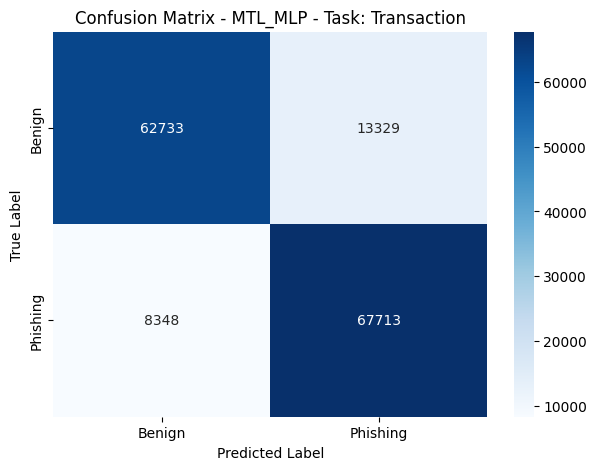


  - Report Task 2: Account-Level


Testing ADDR:   0%|          | 0/1 [00:00<?, ?it/s]

  ✓ ADDR Results (Tổng thể): Acc=0.9154, AUC=0.9531, AvgTime=0.0006 ms
  - Báo cáo chi tiết từng Class (Account):
              precision    recall  f1-score   support

  Benign (0)       0.98      0.90      0.94       568
Phishing (1)       0.81      0.95      0.88       259

    accuracy                           0.92       827
   macro avg       0.89      0.92      0.91       827
weighted avg       0.92      0.92      0.92       827

  - Confusion Matrix (Account)...
  ✓ Đã lưu CM Account tại: /kaggle/working/MTL_MLP/evaluation/confusion_matrix_addr.png


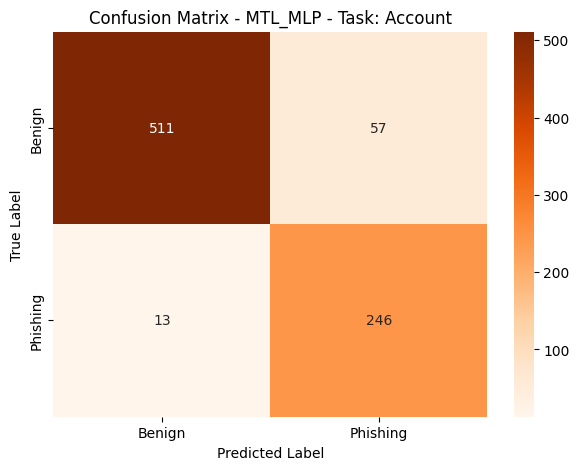

  ✓ Đã lưu kết quả đánh giá (metrics) vào: /kaggle/working/MTL_MLP/evaluation

--- Đánh giá MTL_FTTransformer trên tập Test ---
  - Report Task 1: Transaction-Level


Testing TXN:   0%|          | 0/149 [00:00<?, ?it/s]

  ✓ TXN Results (Tổng thể): Acc=0.7887, AUC=0.9092, AvgTime=0.0025 ms
  - Classification Report (Transaction):
              precision    recall  f1-score   support

  Benign (0)       0.92      0.63      0.75     76062
Phishing (1)       0.72      0.95      0.82     76061

    accuracy                           0.79    152123
   macro avg       0.82      0.79      0.78    152123
weighted avg       0.82      0.79      0.78    152123

  - Confusion Matrix (Transaction)...
  ✓ Đã lưu CM Transaction tại: /kaggle/working/MTL_FTTransformer/evaluation/confusion_matrix_txn.png


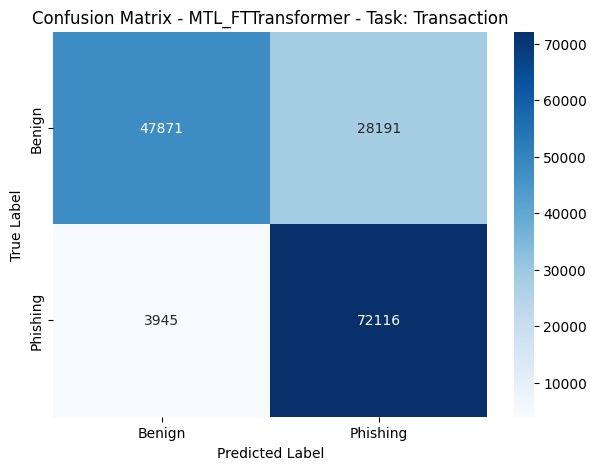


  - Report Task 2: Account-Level


Testing ADDR:   0%|          | 0/1 [00:00<?, ?it/s]

  ✓ ADDR Results (Tổng thể): Acc=0.9129, AUC=0.9644, AvgTime=0.0037 ms
  - Báo cáo chi tiết từng Class (Account):
              precision    recall  f1-score   support

  Benign (0)       0.96      0.91      0.93       568
Phishing (1)       0.82      0.93      0.87       259

    accuracy                           0.91       827
   macro avg       0.89      0.92      0.90       827
weighted avg       0.92      0.91      0.91       827

  - Confusion Matrix (Account)...
  ✓ Đã lưu CM Account tại: /kaggle/working/MTL_FTTransformer/evaluation/confusion_matrix_addr.png


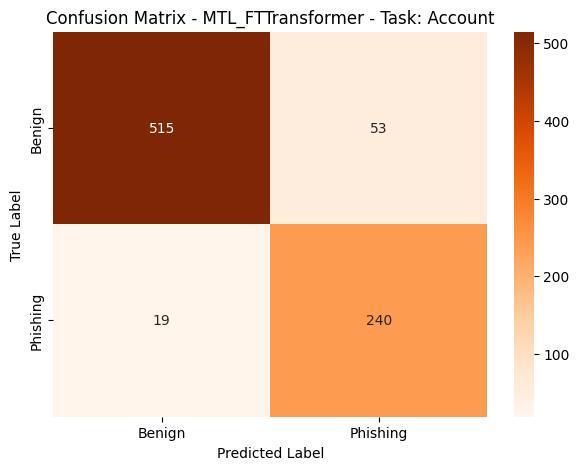

  ✓ Đã lưu kết quả đánh giá (metrics) vào: /kaggle/working/MTL_FTTransformer/evaluation
✓ Hoàn thành đánh giá cả 2 mô hình (kèm CM).


In [8]:
# ============================================================================
# 12. RUN FINAL EVALUATION
# (CHẠY LẠI Ô NÀY)
# ============================================================================
print("\n[12/13] Chạy đánh giá cuối cùng trên tập Test...")

# (Giả định các biến ..._args và ..._path đã được định nghĩa ở code trước)
# ... (code của Step 12) ...

results_mlp = evaluate_model_on_test(
    MTL_MLP, best_model_path_mlp,
    test_txn_loader, test_addr_loader,
    DEVICE, MODEL_NAME_MLP, SAVE_PATH_MLP,
    **mlp_args
)

results_ft = evaluate_model_on_test(
    MTL_FTTransformer, best_model_path_ft,
    test_txn_loader, test_addr_loader,
    DEVICE, MODEL_NAME_FT, SAVE_PATH_FT,
    **ft_args
)

print("✓ Hoàn thành đánh giá cả 2 mô hình (kèm CM).")


[13/13] So sánh kết quả 2 mô hình (Trực quan hóa)...
✓ Đã lưu file so sánh (CSV) tại: /kaggle/working/compare/model_comparison.csv

--- Bảng So Sánh Kết Quả Cuối Cùng (Dạng Bảng) ---
|                                      |   Accuracy |   Precision (Phishing) |   Recall (Phishing) |   F1-Score (Phishing) |    AUC |   Avg_Pred_Time_ms |
|:-------------------------------------|-----------:|-----------------------:|--------------------:|----------------------:|-------:|-------------------:|
| ('MTL_FTTransformer', 'Account')     |     0.9129 |                 0.8191 |              0.9266 |                0.8696 | 0.9644 |             0.0037 |
| ('MTL_FTTransformer', 'Transaction') |     0.7887 |                 0.7190 |              0.9481 |                0.8178 | 0.9092 |             0.0025 |
| ('MTL_MLP', 'Account')               |     0.9154 |                 0.8119 |              0.9498 |                0.8754 | 0.9531 |             0.0006 |
| ('MTL_MLP', 'Transaction')           | 

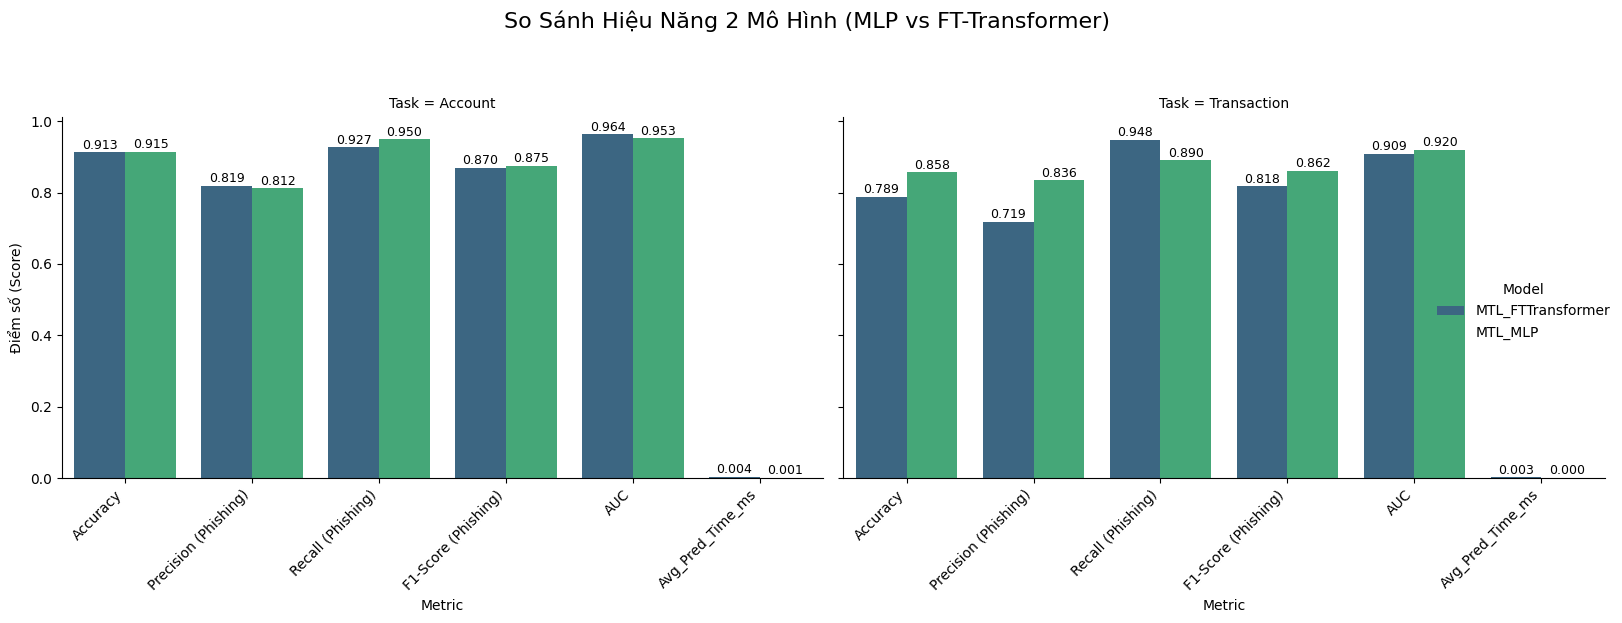


🎉🎉🎉 Hoàn thành toàn bộ pipeline đánh giá! 🎉🎉🎉


In [9]:
# ============================================================================
# 13. COMPARE MODELS - CẬP NHẬT
# (Bao gồm biểu đồ so sánh trực quan)
# ============================================================================
print("\n[13/13] So sánh kết quả 2 mô hình (Trực quan hóa)...")

# Thêm cột Model vào mỗi kết quả
results_mlp['Model'] = MODEL_NAME_MLP
results_ft['Model'] = MODEL_NAME_FT

# Nối các kết quả
comparison_df = pd.concat([results_mlp.reset_index(), results_ft.reset_index()])
comparison_df = comparison_df.set_index(['Model', 'Task']).sort_index()

# Lưu kết quả so sánh
compare_path = "/kaggle/working/compare"
os.makedirs(compare_path, exist_ok=True)
compare_csv_path = os.path.join(compare_path, "model_comparison.csv")
comparison_df.to_csv(compare_csv_path)

print(f"✓ Đã lưu file so sánh (CSV) tại: {compare_csv_path}")

print("\n--- Bảng So Sánh Kết Quả Cuối Cùng (Dạng Bảng) ---")
print(comparison_df.to_markdown(floatfmt=".4f"))

# --- Vẽ Biểu Đồ So Sánh ---
print("\n--- Biểu Đồ So Sánh Trực Quan ---")
try:
    # Chuẩn bị dữ liệu cho plot
    df_plot = comparison_df.reset_index().melt(
        id_vars=['Model', 'Task'], 
        var_name='Metric', 
        value_name='Score'
    )
    
    # Vẽ biểu đồ cột (catplot)
    g = sns.catplot(
        data=df_plot, 
        x='Metric', 
        y='Score', 
        hue='Model', 
        col='Task', 
        kind='bar', 
        height=6, 
        aspect=1.2,
        palette='viridis'
    )
    
    g.fig.suptitle('So Sánh Hiệu Năng 2 Mô Hình (MLP vs FT-Transformer)', y=1.03, fontsize=16)
    g.set_xticklabels(rotation=45, ha='right')
    g.set_axis_labels("Metric", "Điểm số (Score)")
    
    # Thêm text giá trị trên mỗi cột
    for ax in g.axes.flat:
        for p in ax.patches:
            ax.annotate(f"{p.get_height():.3f}", 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        fontsize=9, color='black', 
                        xytext=(0, 5), 
                        textcoords='offset points')

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plot_save_path = os.path.join(compare_path, "model_comparison_plot.png")
    plt.savefig(plot_save_path)
    print(f"\n✓ Đã lưu biểu đồ so sánh tại: {plot_save_path}")
    plt.show()

except Exception as e:
    print(f"\n⚠️ Không thể vẽ biểu đồ: {e}")
    print("  Vui lòng đảm bảo 'results_mlp' và 'results_ft' đã được tạo từ Step 12.")

print("\n🎉🎉🎉 Hoàn thành toàn bộ pipeline đánh giá! 🎉🎉🎉")

In [10]:
!zip -r all_outputs.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/MTL_FTTransformer/ (stored 0%)
  adding: kaggle/working/MTL_FTTransformer/MTL_FTTransformer_best.pth (deflated 10%)
  adding: kaggle/working/MTL_FTTransformer/evaluation/ (stored 0%)
  adding: kaggle/working/MTL_FTTransformer/evaluation/test_metrics.csv (deflated 34%)
  adding: kaggle/working/MTL_FTTransformer/evaluation/confusion_matrix_txn.png (deflated 14%)
  adding: kaggle/working/MTL_FTTransformer/evaluation/confusion_matrix_addr.png (deflated 14%)
  adding: kaggle/working/MTL_FTTransformer/evaluation/test_metrics.json (deflated 58%)
  adding: kaggle/working/MTL_FTTransformer/MTL_FTTransformer_training_plots.png (deflated 8%)
  adding: kaggle/working/Feature_Importance/ (stored 0%)
  adding: kaggle/working/Feature_Importance/AccountLevel_FeatureImportance.png (deflated 19%)
  adding: kaggle/working/Feature_Importance/AccountLevel_top15_features.json (deflated 71%)
  adding: kaggle/working/Feature_Importance/Transaction